In [1]:
from common import *
from pandas.api.types import CategoricalDtype
from numba import njit

from sklearn.preprocessing import QuantileTransformer as QT
from scipy.stats import norm
ppf = norm.ppf

import warnings 
warnings.filterwarnings('ignore')

debug = O()
%matplotlib inline
canvas(9,9)

pd.set_option('display.max_columns', 42)

In [2]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]

In [3]:
'''
N0: N without the too high memory columns (the sets of things columns)
N1: N with the sets of things columns turned into actual Python sets
N2: N with changes in this Notebook. It has these columns: [
       'time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'urgency',
       'takeSequence', 'provider', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetNameId',
       'firstMentionFixed', 'relevance', 'sentimentNegative',
       'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount',
       'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D',
       'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetCodesCount', 'subjectsCount', 'audiencesCount', 'groupbyTime',
       'assetNamesCount'
    ]
N2.class: N2 but also with sentimentClass (maxed on duplicates)
N2.2rel: something additional
N10: N with basic extras: assetNameId, assetNameCount, firstMentionFixed, groupbyTime
N11: idk, I tried to include 'assetNames', frozensets of the assetNames on top of N10, but it came out wrong
''';

In [4]:
M = pd.read_pickle(the_data/'given/M.pkl')
N = pd.read_pickle(the_data/'given/N.pkl')
#test = pd.read_pickle(the_data/'given/test.pkl')

In [5]:
class IdAssign:
    class MISSING():
        pass
    def __init__(self, init, missing=MISSING, name=''):
        self.name = name
        self.map = {}
        if missing is not __class__.MISSING:
            self.map[missing] = -1
        i = 0
        for x in init:
            if x not in self.map and x != missing:
                self.map[x] = i
                i += 1
        self.cache = None
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]
    def __len__(self):
        return self.map.__len__()
    @property
    def series(self):
        if self.cache==len(self):
            return self._series
        self._series = pd.Series(list(self.map.keys()), index=list(self.map.values()), name=self.name)
        self._series.index.name = self.name+'Id'
        self.cache = len(self)
        return self._series

assetCodeSeries = pd.Series(M.assetCode.unique())
assetCodeIdAssign = IdAssign(assetCodeSeries, missing='')
del assetCodeSeries
assetNameSeries = pd.Series(M.assetName.unique())
assetNameIdAssign = IdAssign(assetNameSeries, missing='Unknown')
del assetNameSeries

In [6]:
returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter'
]
column_filter = lambda c: c not in returns_columns and c not in excluded_columns

In [7]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
shortterm = 21
longterm = 250

In [8]:
def add_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign)
    M['assetNameId'] = M.assetName.map(assetNameIdAssign)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log1p(M[orig_col])
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear
    M['dayOfWeek'] = M.time.dt.dayofweek

In [9]:
add_basic_features(M=M)
N['assetNameId'] = N.assetName.map(assetNameIdAssign)

### Code I need to copy elsewhere

In [10]:
def makeMultimap(fr, to):
    ret = {}
    for f, t in zip(fr, to):
        ret.setdefault(f, set()).add(t)
    return ret
assetNameMapCodes = makeMultimap(M.assetNameId, M.assetCodeId)

def makeSinglemap(fr, to):
    ret = {}
    for f, t in zip(fr, to):
        if f in ret:
            assert t==ret[f], 'a "from" element must be mapped to a unique "to" element!'
        else:
            ret[f] = t
    return ret
assetCodeMapName = makeSinglemap(M.assetCodeId, M.assetNameId)


# ------------------------------> looking at `M`

# ------------------------------> looking at `N`

In [14]:
raise Stop('load N2 from pickle')

Stop: load N2 from pickle

#### initial setup

In [30]:
N.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline',
       'urgency', 'takeSequence', 'provider', 'subjects', 'audiences',
       'bodySize', 'companyCount', 'headlineTag', 'marketCommentary',
       'sentenceCount', 'wordCount', 'assetCodes', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetNameId'],
      dtype='object')

In [11]:
#assert '' not in N.assetName and 'Unknown' not in N.assetName

In [ ]:
N['assetNamesCount'] = N[['sourceId','assetNameId']].groupby('sourceId').transform('count')
#N['assetNames'] = N[['sourceId','assetNameId']].groupby('sourceId').transform(frozenset)
N['firstMentionFixed'] = N.firstMentionSentence.replace(0, 999)

@njit
def make_news_groupby_day(ref, col):
    '''Params - ref: np.ndarray {1d} should be something like np.unique(M.time.values)
                col: np.ndarray {1d} should be something like N.time.values
    Return N.time mapped to the corresponding M.time values
    '''
    i, j = 0, 0
    ret = col.copy()
    for j in range(len(col)):
        while ref[i] < col[j]:
            i += 1
        ret[j] = ref[i]
    return ret
N['groupbyTime'] = pd.Series(make_news_groupby_day(np.unique(M.time.values), N.time.values)).astype(M.time.dtype)

In [14]:
newsIdentifying = ('groupbyTime time sourceTimestamp firstCreated sourceId urgency takeSequence provider bodySize '+
                   'companyCount headlineTag marketCommentary sentenceCount wordCount subjectsCount audiencesCount '+
                   'assetNamesCount').split()
['assetNameId'] #< don't forget this!
newsStockBasic = 'assetCodesCount firstMentionFixed relevance'.split()
newsStockSntm = 'sentimentClass sentimentNegative sentimentNeutral sentimentPositive sentimentWordCount'.split()
newsStockNovelty = 'noveltyCount12H noveltyCount24H noveltyCount3D noveltyCount5D noveltyCount7D'.split()
newsStockVolume = 'volumeCounts12H volumeCounts24H volumeCounts3D volumeCounts5D volumeCounts7D'.split()
newsStockTraits = newsStockBasic + newsStockSntm + newsStockNovelty + newsStockVolume
#^ explicitly missing firstMentionSentence (replaced by firstMentionFixed) and

In [16]:
assert ( len(set(N.sourceId)) == len(set(zip(*[N[c] for c in newsIdentifying]))) == 6340206)

In [17]:
N = N.groupby(newsIdentifying+['assetNameId'])[newsStockTraits].max().reset_index() # removes duplicates

In [18]:
assert len(N.groupby(['sourceId','assetNameId']).headlineTag.count().value_counts())==1

In [99]:
%%time

N['relevanceSum'] = N[['sourceId','relevance']].groupby('sourceId').transform(
    lambda x: x.sum() / (x.max() + 1e-6)
)

CPU times: user 2h 24min 22s, sys: 43.3 s, total: 2h 25min 5s
Wall time: 2h 24min 18s


#### load up the transformed bad boys

In [100]:
#N.to_pickle(big_data+'trans/N2.2rel.pkl')
N = pd.read_pickle(big_data+'trans/N2.2rel.pkl')

##### skip on ahead xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [15]:
##S = N.groupby(newsIdentifying).agg(list).reset_index()
#S.to_pickle(big_data+'trans/S.pkl')
#S[newsIdentifying+['assetNameId']+newsStockBasic+newsStockSntm].to_pickle(big_data+'trans/Ssntm.pkl')
S = pd.read_pickle(big_data+'trans/Ssntm.pkl')

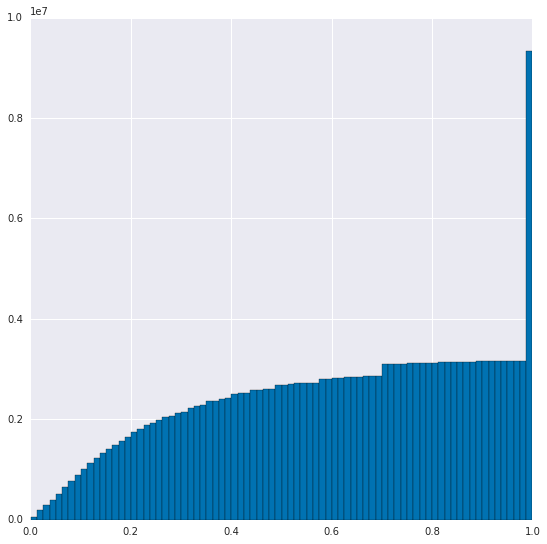

In [94]:
N.relevance.hist(bins=80, cumulative=True);

In [102]:
N['sentimentClassNeg'] = N.sentimentClass==-1
N['sentimentClassFlt'] = N.sentimentClass==0
N['sentimentClassPos'] = N.sentimentClass==1
N['Count'] = 1
N['countBySource'] = 1 / N.assetNamesCount
N['countRelevance'] = N.relevance / N.relevanceSum

In [103]:
NX = (
    N[['groupbyTime','assetNameId','sentimentClass','sentimentClassNeg','sentimentClassFlt','sentimentClassPos',
       'sentimentNegative','sentimentNeutral','sentimentPositive','sentimentWordCount',
       'Count','countBySource','countRelevance']]
    .groupby(['groupbyTime','assetNameId'])
    .sum()
)

##### another save checkpoint

In [104]:
#NX.to_pickle(big_data+'news/sntm_agg.1rel.pkl')
NX = pd.read_pickle(big_data+'news/sntm_agg.1rel.pkl')

In [105]:
NX = NX.reset_index()
NX.sentimentWordCount = np.sqrt(NX.sentimentWordCount)
# filter only assetNames that matched with assetCodes in M #TODO kill unused assetNames from the get go!
usedAssetNames = sorted(assetCodeMapName.values())
xUsedAssetNames = set(usedAssetNames)
NX = NX[NX.assetNameId.isin(xUsedAssetNames)]
#for emo in nx:
#    nx[emo] = nx[emo].loc[:, usedAssetNames]

##### freestyle analysis

In [106]:
M['y'] = M.returnsOpenNextMktres10
globalStd = (M.universe*M.y).std()
grp = M.groupby(M.assetCodeId)[['y','universe']]
assetStds = grp.apply(lambda x: np.sqrt((x.universe*x.y**2).sum()/(x.universe).sum()) if x.universe.sum()>25 else globalStd)
M['yy'] = M.y/M.assetCodeId.map(assetStds)

In [107]:
MN = M[M.assetNameId != -1]

In [108]:
NW = NX.pivot('groupbyTime','assetNameId')
#for c in ['sentimentClass','sentimentClassNeg','sentimentClassFlt','sentimentClassPos','sentimentWordCount','Count']:
#    NW.loc[:, (c, slice(None))] = NW[c].fillna(0, inplace=True)

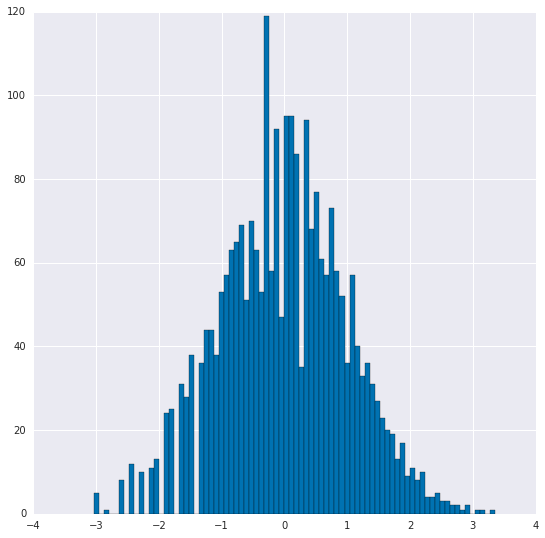

In [129]:
plt.hist(
    np.log1p(NW.Count[np.random.choice(NW.Count.columns, 60, replace=False)].fillna(0).sum(axis=1)).qtl().pipe(ppf)
, bins=80);

#### _the algorithm_

In [217]:
# import xGoodCodes
xCodeSub = xGoodCodes
nameSub = list(map(lambda x: assetCodeMapName[x], xCodeSub))

In [139]:
# from scratch
nameSub = np.random.choice(usedAssetNames, 60, replace=False)#list(xGoodNames)
xNameSub = set(nameSub)
xCodeSub = set.union(*(assetNameMapCodes[nm] for nm in nameSub))

In [137]:
x = O(**{k: np.log1p(v.loc[:, nameSub].sum(axis=1)) for k,v in dict.items(mn)})

NameError: name 'mn' is not defined

In [109]:
V = O(y=M[['time','assetCodeId','yy']].pivot('time','assetCodeId').yy)

In [110]:
Y = V.y

In [242]:
#assert (x.pos.index == V.y.index).all()

In [243]:
y = V.y.T[V.y.T.index.isin(xCodeSub)].sum()

In [244]:
X = np.stack([x.neg, x.flt, x.pos], axis=1)

In [245]:
pd.DataFrame({'x.cnt': x.cnt, 'y': y}).corr()

,x.ratio,y
x.ratio,1.000000,0.004778
y,0.004778,1.000000


In [226]:
theData = data*0+zca
def get_test_corr(n):
    for i in range(n):
        # from scratch
        nameSub = np.random.choice(usedAssetNames, 60, replace=False)#list(xGoodNames)
        #nameSub1 = np.random.choice(usedAssetNames, 20, replace=False)#list(xGoodNames)
        xCodeSub = set.union(*(assetNameMapCodes[nm] for nm in nameSub))
        x = np.log1p(theData.loc[:, nameSub].sum(axis=1))
        y = Y.T[Y.T.index.isin(xCodeSub)].sum()
        yield pd.DataFrame({'x':x,'y':y}).corr().values[0,1]

In [227]:
corrs = sorted(get_test_corr(500))
corrs

[-0.086803365216808648,
 -0.071838337595214269,
 -0.069702809563930268,
 -0.066246479497691163,
 -0.06503986500004412,
 -0.062064147811409349,
 -0.06198777100950624,
 -0.061451309174354221,
 -0.06018691377558081,
 -0.058760257102475802,
 -0.057641300978320723,
 -0.055865901989506174,
 -0.054985081412350791,
 -0.054951706172328661,
 -0.054901725293645495,
 -0.054742079145381289,
 -0.054265787209700184,
 -0.053482146894466662,
 -0.053141579839048776,
 -0.053135192819767148,
 -0.053111928914291374,
 -0.052552405222276277,
 -0.052481414389895023,
 -0.052453717991487181,
 -0.05178286036772016,
 -0.051397885599303118,
 -0.050921296628514787,
 -0.050002031781588845,
 -0.049631065749610487,
 -0.049600873034092378,
 -0.049011971403122009,
 -0.048583491689267254,
 -0.048192458439581996,
 -0.047917874015578531,
 -0.047901731208527469,
 -0.047800260406503696,
 -0.047450592753179047,
 -0.04717601263449437,
 -0.046865301086643017,
 -0.046817834115064766,
 -0.046515010825024218,
 -0.04648207844606527

testing

In [149]:
corr, m = -.20, 15
x = np.random.normal(size=[1000,m])
y = np.random.normal(size=[1000,m])*np.sqrt(1-corr**2)+x*corr

In [150]:
#pd.DataFrame({'x': x.flatten(), 'y': y.flatten()}).corr()

In [151]:
t = (-np.sign(x) * y).sum(axis=1)
print(t.mean()/t.std(ddof=0))
#plt.hist(t, bins=80);

0.671688036584


#### current S work, depreciated because it doesn't work

In [31]:
def iter_graph_gen_feed(an):
    for a in an:
        yield from a
        yield -2

In [ ]:
ggf = list(iter_graph_gen_feed(S.assetNameId))

In [160]:
@njit
def make_adj_mat(ggf):
    n = 0
    for x in ggf:
        n = x if x>n else n
    n += 1 # n is just max(ggf)+1
    adj = np.zeros((n, n), dtype=np.float64)
    grp = [-1][:0]
    for x in ggf:
        if x != -2:
            grp.append(x)
        else:
            m = len(grp)
            assert m>0
            if m>1:
                w = 1 / (m*(m-1)//2)
                for i in range(m-1):
                    for j in range(i+1, m):
                        adj[grp[i], grp[j]] += w
                        adj[grp[j], grp[i]] += w
            for i in range(m):
                adj[grp[i], grp[i]] += 1 / m
            grp = [-1][:0]
    return adj

In [161]:
adj = make_adj_mat(ggf)

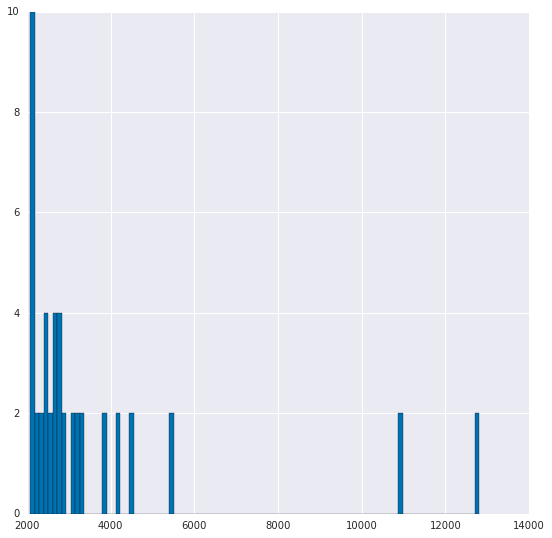

In [199]:
a = offdiag(adj)
a = a[a>2000]
plt.hist(a, bins=100);

In [84]:
@njit
def iter_cc_min_weight(adj, w):
    seen = {-1}; seen.remove(-1)
    for i in range(adj.shape[0]):
        if i in seen:
            continue
        cc = {-1}; cc.remove(-1)
        front = [i]
        while front:
            i = front.pop()
            cc.add(i)
            for j in range(adj.shape[1]):
                if adj[i, j] < w or j in seen:
                    continue
                seen.add(j)
                front.append(j)
        yield cc


In [200]:
ccs = list(iter_cc_min_weight(adj, 1000))

In [201]:
ccsSize = [len(cc) for cc in ccs]
ccsSize2 = [len(cc) for cc in ccs if len(cc)>1]

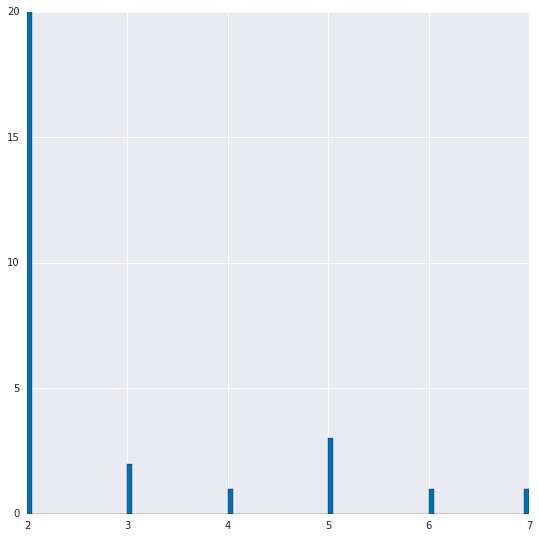

In [202]:
plt.hist(np.clip(ccsSize2, 0, 50), bins=100);

In [189]:
adj

array([[  2.90582315e+03,   5.33333333e-01,   3.58291087e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.33333333e-01,   1.42011878e+03,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.58291087e-02,   0.00000000e+00,   1.03486648e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.79646465e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   8.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00]])

### old work from old subseted S

In [80]:
S.assetNamesCount.value_counts()

2     515045
3     185370
4     113726
5      79088
6      50150
7      25458
8      12343
9       9279
10      6645
11      5034
12      4060
13      2960
40      2723
39      2416
14      2239
15      1693
41      1412
16      1302
38      1253
17      1192
18      1053
37       839
19       833
20       779
21       639
22       596
23       585
36       585
24       556
28       533
25       530
26       481
27       446
35       415
32       408
29       400
30       400
34       390
33       386
31       385
42       270
43        12
Name: assetNamesCount, dtype: int64

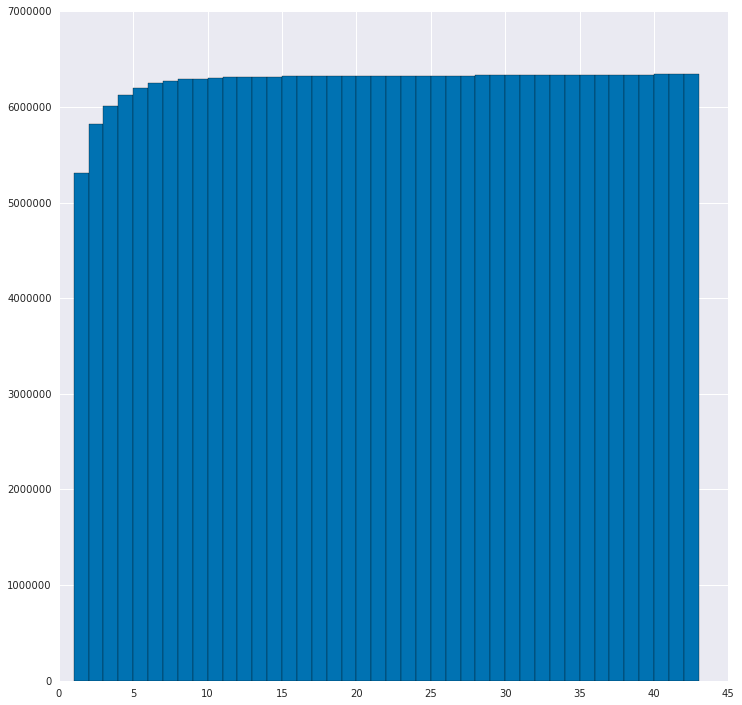

In [113]:
S.assetNamesCount.hist(bins=42,cumulative=True);

In [85]:
S2 = S[S.assetNamesCount==2]

In [109]:
diff = pd.Series([abs(a[0]-a[1]) for a in S2.sentimentNegative], index=S2.index)
S2diff = S2[diff>.8]

In [110]:
for i in np.random.choice(range(len(S2diff)), 50):
    sourceId = S2diff.index[i]
    assetNameIds = N[N.sourceId==sourceId].assetNameId.values
    print(assetNameIdAssign.series[assetNameIds[0]], '|', assetNameIdAssign.series[assetNameIds[1]])

Enerplus Corp | CAE Inc
Bank of Montreal | Canadian Imperial Bank of Commerce
KB Home | Lennar Corp
Cameco Corp | Denison Mines Corp
Goldman Sachs Group Inc | Royal Bank of Scotland Group PLC
Reynolds American Inc | Lorillard LLC
ARM Holdings PLC | Subsea 7 SA
Huntington Bancshares Inc | Franklin Credit Holding Corp
Unilever PLC | Ryanair Holdings PLC
Deutsche Bank AG | Siemens AG
Telefonica SA | Vodafone Group PLC
ING Groep NV | Cadbury Ltd
Ciena Corp | Pandora Media Inc
CNOOC Ltd | Total SA
Health Net Inc | CubeSmart
M&T Bank Corp | Transocean Inc
Barclays PLC | UBS AG
Barclays PLC | Royal Dutch Shell PLC
Bristol-Myers Squibb Co | Mallinckrodt Hospital Products Inc
BHP Billiton Ltd | Alumina Ltd
ConocoPhillips | Chevron Corp
Banco Santander SA | Fiat Chrysler Automobiles NV
Medimmune LLC | Exxon Mobil Corp
Bazaarvoice Inc | Twitter Inc
E. W. Scripps Co | Leaf Group Ltd
Syngenta AG | UBS AG
Ford Motor Co | General Motors Co
Nokia Oyj | ASML Holding NV
Vonage Holdings Corp | Verizon Co

In [25]:
'ready'

'ready'

In [26]:
def iter_plot_guys(xarrs, yarrs):
    for g, (xs, ys) in enumerate(zip(xarrs, yarrs)):
        n = len(xs)
        assert n==len(ys)
        if n > 10:
            continue
        group = []
        for i in range(0, n-1):
            for j in range(i+1, n):
                group.append( (xs[i], xs[j], ys[i], ys[j]) )
        yield i, n, group

In [27]:
%%time
guy = list(iter_plot_guys(S.sentimentNegative.values, S.sentimentPositive.values))

CPU times: user 11.3 s, sys: 576 ms, total: 11.9 s
Wall time: 11.9 s


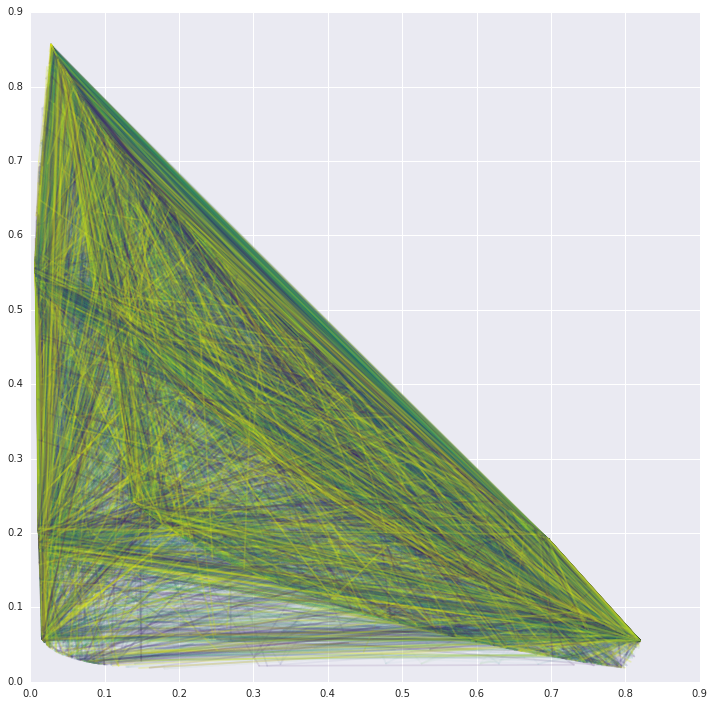

In [32]:
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
cmap = plt.get_cmap('viridis')
for g, n, group in random.sample(guy, 100000):
    alpha = 1/n**2
    c = cmap(hash(str(g)) % 256)
    for x0, x1, y0, y1 in group:
        ax.plot((x0, x1), (y0, y1), alpha=alpha, c=c)

### really old stuff..................................................................................................................................

In [ ]:
N.groupby('time').

### old

#### just see for now

In [7]:
list(zip(N.columns,N.dtypes))

[('time', datetime64[ns, UTC]),
 ('sourceTimestamp', datetime64[ns, UTC]),
 ('firstCreated', datetime64[ns, UTC]),
 ('sourceId', dtype('O')),
 ('headline', dtype('O')),
 ('urgency', dtype('int8')),
 ('takeSequence', dtype('int16')),
 ('provider', dtype('O')),
 ('subjects', dtype('O')),
 ('audiences', dtype('O')),
 ('bodySize', dtype('int32')),
 ('companyCount', dtype('int8')),
 ('headlineTag', dtype('O')),
 ('marketCommentary', dtype('bool')),
 ('sentenceCount', dtype('int16')),
 ('wordCount', dtype('int32')),
 ('assetCodes', dtype('O')),
 ('assetName', dtype('O')),
 ('firstMentionSentence', dtype('int16')),
 ('relevance', dtype('float32')),
 ('sentimentClass', dtype('int8')),
 ('sentimentNegative', dtype('float32')),
 ('sentimentNeutral', dtype('float32')),
 ('sentimentPositive', dtype('float32')),
 ('sentimentWordCount', dtype('int32')),
 ('noveltyCount12H', dtype('int16')),
 ('noveltyCount24H', dtype('int16')),
 ('noveltyCount3D', dtype('int16')),
 ('noveltyCount5D', dtype('int16'))

In [31]:
aNames = M.groupby('assetNameId').assetCodeId.apply(set).map(len)

In [44]:
guy = aNames[aNames==2]
guy.index = guy.index.map(assetNameSeries)

In [49]:
N.shape

(9328750, 34)

In [53]:
N.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'urgency',
       'takeSequence', 'provider', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetCodesCount', 'subjectsCount', 'audiencesCount'],
      dtype='object')

#### actual analysis

In [13]:
dup = N.duplicated(['sourceId', 'assetName'], keep=False)

In [25]:
dup.sum()

1034

In [28]:
N.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'urgency',
       'takeSequence', 'provider', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetCodesCount', 'subjectsCount', 'audiencesCount'],
      dtype='object')

In [47]:
dup1 = N.duplicated((
    'time sourceTimestamp firstCreated sourceId urgency takeSequence provider bodySize companyCount headlineTag '+
    'marketCommentary sentenceCount wordCount assetName firstMentionSentence'# relevance'# sentimentClass'
    #'sentimentNegative sentimentNeutral sentimentPositive sentimentWordCount assetCodesCount subjectsCount audiencesCount'
).split(), keep=False)

In [49]:
N[dup&~dup1]

,time,sourceTimestamp,firstCreated,sourceId,urgency,takeSequence,provider,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,assetCodesCount,subjectsCount,audiencesCount
1541658,2009-01-13 20:49:02+00:00,2009-01-13 20:49:02+00:00,2009-01-13 20:49:02+00:00,32a355426b7e99a5,3,1,BSW,2411,2,,False,13,357,BBX Capital Corp,0,0.129099,1,0.116639,0.385302,0.498059,357,0,0,0,0,0,0,0,0,0,0,2,13,2
1541659,2009-01-13 20:49:02+00:00,2009-01-13 20:49:02+00:00,2009-01-13 20:49:02+00:00,32a355426b7e99a5,3,1,BSW,2411,2,,False,13,357,BBX Capital Corp,1,1.000000,1,0.116639,0.385302,0.498059,357,1,1,1,1,1,1,1,2,2,2,1,13,2
1612220,2009-02-10 13:01:09+00:00,2009-02-10 13:01:09+00:00,2009-02-10 13:01:09+00:00,005b54d8d7c192bd,3,1,BSW,41612,2,,False,196,6776,BBX Capital Corp,1,1.000000,-1,0.741750,0.190933,0.067317,3996,1,1,1,1,1,1,2,2,2,2,1,11,2
1612221,2009-02-10 13:01:09+00:00,2009-02-10 13:01:09+00:00,2009-02-10 13:01:09+00:00,005b54d8d7c192bd,3,1,BSW,41612,2,,False,196,6776,BBX Capital Corp,0,0.017025,-1,0.769580,0.153629,0.076791,6776,0,0,0,0,0,0,0,0,0,0,2,11,2
1641994,2009-02-21 02:00:02+00:00,2009-02-21 02:00:02+00:00,2009-02-21 02:00:02+00:00,08b4727c4dd4e350,3,1,BSW,5350,2,,False,22,839,BBX Capital Corp,1,1.000000,1,0.136571,0.390357,0.473072,527,0,0,0,0,0,0,0,0,4,4,1,9,2
1641995,2009-02-21 02:00:02+00:00,2009-02-21 02:00:02+00:00,2009-02-21 02:00:02+00:00,08b4727c4dd4e350,3,1,BSW,5350,2,,False,22,839,BBX Capital Corp,0,0.174078,1,0.388673,0.188492,0.422835,839,0,0,0,0,0,0,0,0,0,0,2,9,2
1706051,2009-03-20 15:02:02+00:00,2009-03-20 15:02:02+00:00,2009-03-20 15:02:02+00:00,4906de5884de4f4c,3,1,BSW,5340,2,,False,28,869,BBX Capital Corp,1,1.000000,0,0.198182,0.446870,0.354948,822,0,0,0,0,0,0,0,0,0,0,1,9,2
1706052,2009-03-20 15:02:02+00:00,2009-03-20 15:02:02+00:00,2009-03-20 15:02:02+00:00,4906de5884de4f4c,3,1,BSW,5340,2,,False,28,869,BBX Capital Corp,0,0.064282,0,0.208822,0.521010,0.270168,869,0,0,0,0,0,0,0,0,0,0,2,9,2
1788206,2009-04-30 18:07:02+00:00,2009-04-30 18:07:02+00:00,2009-04-30 18:07:02+00:00,a1b64a459e803ecb,3,1,BSW,6022,2,,False,31,922,BBX Capital Corp,1,1.000000,-1,0.596914,0.134716,0.268370,768,0,0,0,0,0,0,0,1,3,3,1,10,2
1788207,2009-04-30 18:07:02+00:00,2009-04-30 18:07:02+00:00,2009-04-30 18:07:02+00:00,a1b64a459e803ecb,3,1,BSW,6022,2,,False,31,922,BBX Capital Corp,0,0.235702,-1,0.752587,0.149126,0.098287,922,0,0,0,0,0,0,0,0,0,0,2,10,2


#### testing things

In [215]:
W.x = Mpost2009[['time','assetCodeId','returnsOpenPrevRaw10']].pivot('time','assetCodeId').returnsOpenPrevRaw10
assert W.x.columns.is_monotonic_increasing
W.x_ = W.x.fillna(0)

In [216]:
W.x0 = Mpost2009[['time','assetCodeId','returnsOpenPrevMktres10']].pivot('time','assetCodeId').returnsOpenPrevMktres10
assert W.x0.columns.is_monotonic_increasing
W.x0_ = W.x0.fillna(0)

In [217]:
W.m = Mpost2009[['time','assetCodeId','volume']].pivot('time','assetCodeId').volume
assert W.m.columns.is_monotonic_increasing
W.m_ = W.m.fillna(0)

In [218]:
mkt = (W.m*W.x).sum(axis=1)/W.m.sum(axis=1)

In [219]:
((W.x-W.x0).T/mkt).T

assetCodeId,0,1,2,3,4,5,6,7,8,9,11,12,13,14,16,18,19,20,21,23,24,...,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02 22:00:00+00:00,-0.286238,-0.238825,-0.532593,-0.585000,-0.502946,-0.049359,NaN,-0.658562,-0.096426,-0.102341,-1.598997,-1.328766,-0.378774,0.012446,-0.138426,-0.320111,0.081789,-0.123394,-0.305771,-0.402522,-0.651738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 22:00:00+00:00,0.751820,0.414946,1.510691,1.603174,1.354565,0.065711,NaN,1.818368,0.194107,0.176863,4.623157,3.588696,0.941656,-0.104154,0.304169,0.858482,-0.055280,0.188228,0.764896,1.083741,1.555285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06 22:00:00+00:00,0.443377,0.143440,0.832794,0.917034,0.752397,0.014361,NaN,1.014152,0.087174,0.070528,2.654196,1.972144,0.508402,-0.055451,0.131683,0.486397,0.067872,0.081801,0.393818,0.589392,0.813714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07 22:00:00+00:00,0.464773,0.152005,0.836005,0.929860,0.753582,0.023313,NaN,1.006127,0.093312,0.107206,2.631259,1.983367,0.506257,-0.056730,0.138937,0.521848,0.101152,0.113567,0.385022,0.585677,0.890838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08 22:00:00+00:00,0.355117,0.264468,0.687582,0.754501,0.673875,-0.103619,NaN,0.638288,0.004878,0.271129,1.925286,1.779763,0.181801,-0.153333,0.179668,0.594861,0.010998,0.267528,0.228242,0.399750,0.800626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-09 22:00:00+00:00,0.587281,-0.180737,0.617214,0.721903,0.575984,-0.023535,NaN,0.421974,-0.040442,0.670758,1.211331,1.746648,0.051098,-0.200385,0.438147,0.877567,0.126810,0.574675,0.307011,0.234545,0.808701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-12 22:00:00+00:00,0.291191,-0.112425,0.265186,0.325308,0.271758,0.007221,NaN,0.174721,-0.020705,0.335618,0.525014,0.723563,0.005746,-0.083144,0.221980,0.402134,0.090884,0.278923,0.149471,0.103125,0.355982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-13 22:00:00+00:00,-0.220372,0.081928,-0.217668,-0.254060,-0.264797,-0.036637,NaN,-0.132739,0.012374,-0.294366,-0.411933,-0.562523,0.009019,0.041517,-0.196620,-0.331608,-0.120873,-0.247188,-0.146270,-0.084567,-0.320839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-14 22:00:00+00:00,-7.575463,3.415298,-10.115035,-11.511187,-13.423123,-0.920072,NaN,-6.399159,0.478344,-13.656712,-18.613715,-27.519399,0.257222,3.194654,-6.624606,-13.573865,-0.569371,-10.994983,-7.414404,-3.728343,-14.810767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## --------------------------> `W` work ================================

In [33]:
Mpost2009 = M[M.time>=train_start_time]
W = O()
w = O()

In [37]:
theM = Mpost2009

In [ ]:
W

In [62]:
W.y = theM[['time','assetCodeId','oo_10']].pivot('time','assetCodeId').oo_10
assert W.y.columns.is_monotonic_increasing
W.y_ = W.y.fillna(0)
W.y0 = theM[['time','assetCodeId','oo0_10']].pivot('time','assetCodeId').oo0_10
assert W.y0.columns.is_monotonic_increasing
W.y0_ = W.y0.fillna(0)
############
W.yy = theM[['time','assetCodeId','oo']].pivot('time','assetCodeId').oo
assert W.yy.columns.is_monotonic_increasing
W.yy_ = W.yy.fillna(0)
W.yy0 = theM[['time','assetCodeId','oo0']].pivot('time','assetCodeId').oo0
assert W.yy0.columns.is_monotonic_increasing
W.yy0_ = W.yy0.fillna(0)

In [63]:
%matplotlib notebook
canvas(9.5, 4)

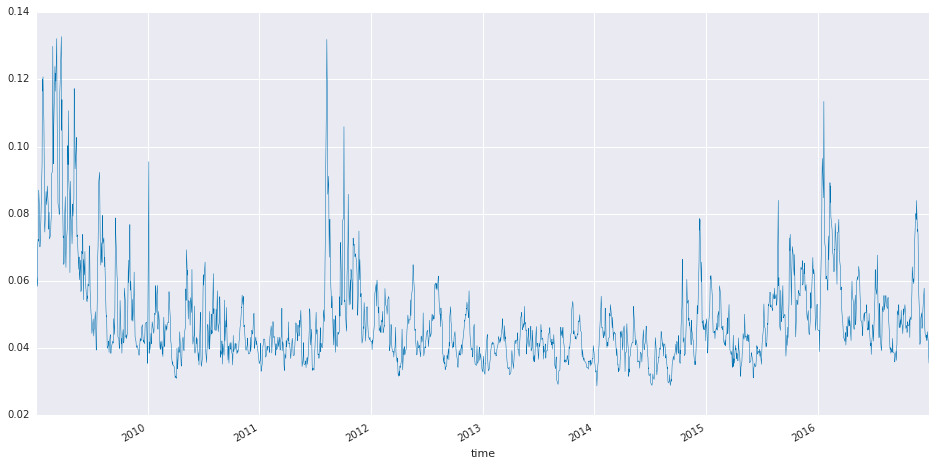

In [461]:
W.y_.std(axis=1).plot(linewidth=.5);

In [501]:
M.volume.isna().any(0)

False

In [499]:
stocksInUni = (theM.groupby('assetCodeId').universe.sum() != 0).nonzero()[0]
xStocksInUni = set(seenUniverse)

In [500]:
lens(theM[theM.assetCodeId.isin(xSeenUniverse)], theM)

(2377748, 3340144)

### Random Number Generation

In [448]:
@njit
def shiftWrap32(num, shift):
    d = np.uint8(32)
    n = np.uint32(num & 0xFFFFFFFF) # coerce num to a int32 value
    i = np.uint8(shift % d) # coerce shift to a int8 value
    return np.uint32(n << i) | np.uint32(n >> (d-i))

In [194]:
(1<<32)-1

4294967295

In [191]:
shiftWrap32(0xFFFFFFFF, 0)

4294967295

In [167]:
'{:b}'.format(

32

In [265]:
i = 8
j = 4
shiftWrap32(i, j**2) ^ ~shiftWrap32(i, (j+1)**2) ^ shiftWrap32(i, (j+2)**2)# ^ ~shiftWrap32(i, (j+3)**2)

-268959873

In [ ]:
@njit
def randomThing(i, j):
    return (
        ((0x80085111 ^ shiftWrap32(i, j**2)) * 
        #(0xFA100000 - ~shiftWrap32(i, (j+1)**2))) * 
        #((0x1337C0DE + shiftWrap32(i, (j+2)**2)) ^ 
        (0xABCDEF77 ^ shiftWrap32(i, (j+3)**2)))
    )

@memo
def randMap32(ident):
    i = ident
    @njit
    def func(n):
        s = shiftWrap32
        x = n
        x *= randomThing(i, 777) | 0x5558982A
        x += randomThing(i, 263435)
        x *= x
        x = (x >> 8) + (x << 8)
        x ^= randomThing(i, 2000004444)
        x *= x
        return x
    return func

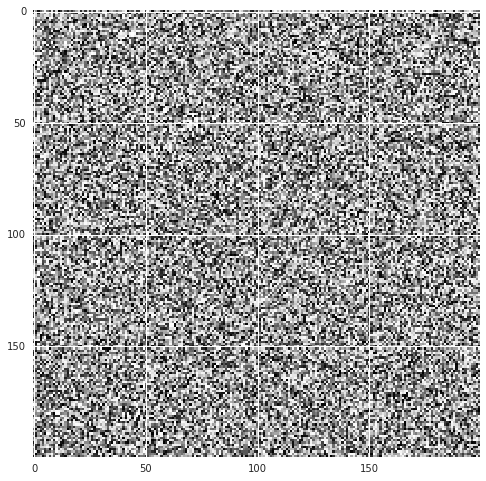

In [447]:
many = 200
guy = np.asarray([[randMap32(i)(j) for j in range(many)] for i in range(many)])
plt.imshow(guy, interpolation='None');

### Continuing on with W...........................

In [503]:
stocksInUni = (M[M.time>=train_start_time].groupby('assetCodeId').universe.sum() != 0).pipe(lambda x: x.index[x])
assert stocksInUni.is_monotonic
xStocksInUni = set(stocksInUni) #EDITCELL

In [505]:
U = O()
for c in W:
    U[c] = W[c].T[W[c].columns.isin(xStocksInUni)].T

In [508]:
U.y.corr()

assetCodeId,0,2,3,4,5,7,8,9,11,12,13,14,16,18,19,20,21,23,24,25,27,...,3698,3710,3717,3729,3731,3737,3741,3745,3749,3750,3753,3755,3756,3760,3761,3762,3765,3767,3769,3771,3774
assetCodeId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.096582,0.384056,0.503202,0.478663,0.409887,0.388186,0.442527,0.512379,0.448493,0.311381,0.124491,0.370561,0.547447,0.360675,0.592549,0.305719,0.521155,0.586863,0.416786,0.406305,...,0.213531,-0.000550,0.160432,0.521922,0.141763,-0.232702,-0.498755,0.545850,0.461737,-0.814451,-0.737613,0.894791,0.358080,0.673316,0.816579,-0.393561,-0.724090,-0.494959,0.409001,0.304585,-0.366178
2,0.096582,1.000000,0.200836,0.098647,0.123572,0.208032,0.156700,0.153790,0.057412,0.109977,0.049507,0.131743,0.181766,0.168335,0.055045,0.346415,0.218519,0.189826,0.164580,0.174923,0.090649,...,0.121261,-0.238833,0.446533,0.753936,0.381019,-0.443437,0.220811,0.017121,0.584082,0.125403,0.333891,0.317249,0.864553,0.831519,0.855741,-0.280796,-0.584364,-0.130893,0.421259,0.161076,0.592381
3,0.384056,0.200836,1.000000,0.412629,0.279193,0.260474,0.309373,0.346548,0.549438,0.500600,0.338292,0.445337,0.278075,0.381451,0.315099,0.496343,0.300454,0.445884,0.452543,0.226187,0.168467,...,0.440461,0.001030,0.513636,-0.199682,0.416758,-0.267639,0.609932,0.539033,0.025197,-0.296209,-0.604564,0.440557,-0.355818,-0.051998,0.313038,-0.688420,-0.442520,-0.205480,0.314193,0.217919,-0.749336
4,0.503202,0.098647,0.412629,1.000000,0.322117,0.444536,0.353786,0.553181,0.579532,0.707861,0.434897,0.330480,0.337370,0.501205,0.384215,0.578670,0.473714,0.439126,0.556061,0.376822,0.271128,...,0.531226,0.213383,0.539718,0.328713,-0.018997,-0.592636,-0.656968,0.296115,0.492705,-0.477194,-0.059489,0.404154,0.461375,0.811064,0.591877,-0.029725,-0.399558,-0.172855,0.119696,0.674772,0.718831
5,0.478663,0.123572,0.279193,0.322117,1.000000,0.144497,0.474609,0.350009,0.316976,0.256650,0.259324,0.234647,0.261101,0.339882,0.093046,0.422940,0.223783,0.375641,0.396521,0.217679,0.230836,...,0.124509,0.411197,0.570105,0.463719,-0.013197,-0.534645,-0.248131,-0.070396,-0.505548,0.116271,0.124077,-0.535963,-0.587321,-0.347309,-0.574099,0.247281,0.708572,0.568577,-0.286409,0.686112,0.878392
7,0.409887,0.208032,0.260474,0.444536,0.144497,1.000000,0.077581,0.327111,0.642586,0.347345,0.256514,0.256174,0.244630,0.455914,0.531673,0.416800,0.236754,0.458369,0.354432,0.351759,0.193814,...,0.088398,0.210340,0.031149,0.658113,0.114157,-0.032767,0.045112,-0.297656,-0.161476,0.796496,0.661375,-0.556300,0.155270,-0.031203,-0.284635,0.700705,0.649827,0.663067,0.045412,0.421090,0.964398
8,0.388186,0.156700,0.309373,0.353786,0.474609,0.077581,1.000000,0.313920,0.092346,0.153750,0.305008,0.220735,0.203093,0.309631,-0.013572,0.298077,0.354431,0.303328,0.323158,0.120278,0.343498,...,0.331886,-0.103011,0.058721,0.549182,0.277109,-0.155933,-0.183196,0.390494,0.442708,-0.789225,-0.747431,0.820955,0.306287,0.637152,0.728541,-0.378738,-0.749837,-0.510531,0.438964,0.558700,0.439362
9,0.442527,0.153790,0.346548,0.553181,0.350009,0.327111,0.313920,1.000000,0.606450,0.558612,0.437287,0.326797,0.195561,0.451617,0.322938,0.467865,0.327996,0.426054,0.470707,0.229506,0.336681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.512379,0.057412,0.549438,0.579532,0.316976,0.642586,0.092346,0.606450,1.000000,0.645817,0.448477,0.256957,0.329326,0.720441,0.587799,0.439975,0.245684,0.568758,0.668656,0.508411,0.356998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### original (oldish) W/NW work

In [13]:
W.x = Mpost2009[['time','assetCodeId','oo_10']].pivot('time','assetCodeId').oo_10
assert W.x.columns.is_monotonic_increasing
W.x_ = W.x.fillna(0)

In [80]:
allStd = nonnans(W.x.values.flatten()).std()
w.cnt = W.x.count()
w.std = np.sqrt((W.x**2).sum()/(w.cnt-1))
w.std = w.std.replace(np.inf, 0) * (w.cnt>=25) + allStd * (w.cnt<25)

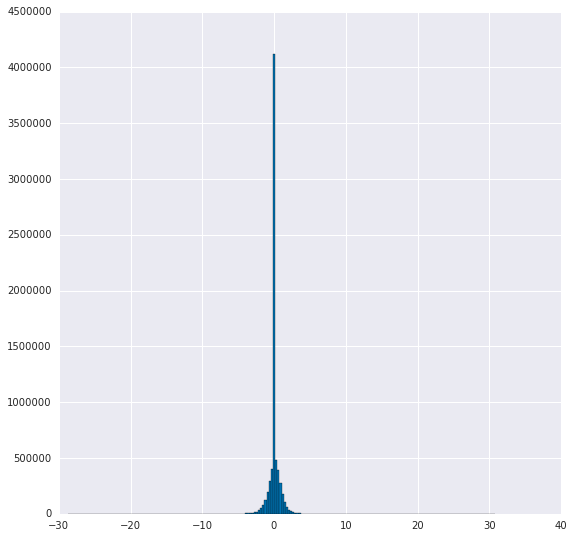

In [56]:
plt.hist(nonnans((W.x_/w.std).values.flatten()), bins=200);

In [9]:
C = O()
C.x = np.corrcoef(W.x_, rowvar=False)

In [77]:
Cfilt = C.x[sfilt].T[sfilt].T
Cclean = ((1-Cfilt+.03)/1.5)

In [95]:
Cqtl = pd.Series(Cfilt.flatten()).qtl().values.reshape(Cfilt.shape)

In [228]:
from sklearn.decomposition import (
    PCA, FastICA,FactorAnalysis as FA, KernelPCA, SparsePCA, MiniBatchSparsePCA as MBSparsePCA,NMF
)
from sklearn.manifold import TSNE
from hdbscan import HDBSCAN
from matplotlib import markers

### Plain PCA

In [144]:
NWpost2009 = NW[NW.index>=train_start_time]
NWpost2009.shape

(2014, 37818)

In [194]:
inStocks = NWpost2009.countRelevance.columns[ (NWpost2009.countRelevance>1).sum() > 500 ]
theNW = NWpost2009.countRelevance.loc[:, inStocks].fillna(0)

In [195]:
theNW.shape

(2014, 363)

In [196]:
f = PCA(363)
f = f.fit(theNW)
pcs = f.transform(theNW)

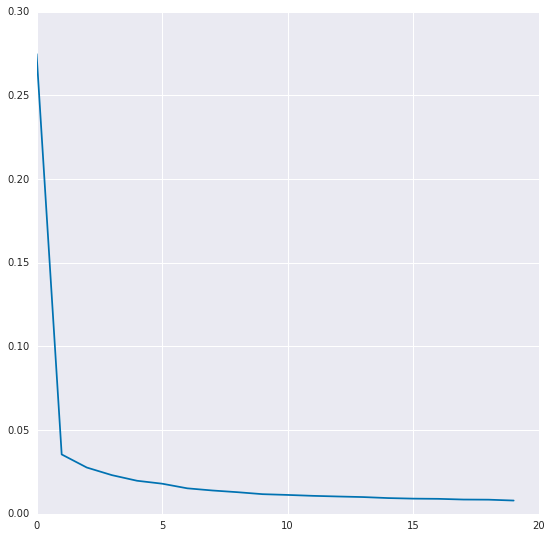

In [197]:
plt.plot(f.explained_variance_ratio_[:20]);

In [199]:
c = 0

# the market return is the first PC
mkt_return = pcs[:,c,np.newaxis] #shape=[Ndays, 1]

# the betas of each stock to the market return are in
# the first column of the components
mkt_beta = f.components_[c,:,np.newaxis] #shape=[Nstock, 1]

# the market portion of returns is the projection of one onto the other
mkt_portion = mkt_beta.dot(mkt_return.T).T

# ...and the residual is just the difference
residual = theNW - mkt_portion

In [200]:
theNW

assetNameId,0,3,4,8,11,16,19,20,22,30,33,37,42,61,62,66,70,74,80,81,82,...,2891,2895,2899,2902,2930,2951,2966,3005,3006,3145,3186,3248,3285,3314,3321,3350,3391,3423,3431,3484,3486
groupbyTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02 22:00:00+00:00,0.000000,0.415900,0.000000,0.188982,1.000001,0.000000,0.000000,0.000000,0.000000,1.000001,0.068042,0.000000,0.000000,0.000000,0.000000,0.000000,0.089087,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.261388,0.000000,0.987482,0.000000,0.000000,0.000000,0.000000,2.511667,0.068042,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000,0.974997,0.000000,0.000000,0.000000,0.000000
2009-01-05 22:00:00+00:00,1.000001,21.034727,0.000000,0.000000,3.000004,0.500000,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,0.124036,0.000000,0.105916,0.235703,0.000000,0.000000,0.000000,2.083088,...,0.198039,0.000000,0.000000,0.230817,0.000000,6.239462,0.000000,1.000001,0.706199,0.000000,0.000000,0.099020,1.000001,1.087843,2.000002,1.000001,1.000001,0.000000,0.000000,0.000000,0.041842
2009-01-06 22:00:00+00:00,0.000000,40.063695,0.000000,1.500001,1.783117,0.000000,0.000000,0.000000,1.000001,0.000000,0.445257,1.335805,0.000000,4.000004,1.120992,2.000002,0.068465,0.000000,2.754588,0.000000,0.126151,...,0.057166,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,1.645849,1.000001,0.250000,0.000000,1.000001,5.549233,14.000014,0.000000,7.288683,1.000001,0.000000,0.000000,13.000013
2009-01-07 22:00:00+00:00,0.000000,2.740684,0.000000,0.064558,0.000000,0.000000,0.000000,0.000000,0.000000,0.258200,2.425183,0.062994,0.000000,0.000000,0.000000,0.894428,0.217024,1.000001,0.000000,0.000000,0.593062,...,0.957353,0.000000,0.000000,2.136085,0.000000,0.000000,0.000000,0.000000,2.051303,2.060663,0.000000,0.126534,0.000000,0.340317,11.000011,0.000000,16.821057,0.000000,0.000000,1.000001,20.877502
2009-01-08 22:00:00+00:00,0.000000,1.790380,0.511033,0.000000,0.120950,0.000000,0.000000,0.000000,1.000001,1.000001,2.000002,0.000000,0.000000,0.201805,0.000000,0.000000,3.260099,0.000000,7.855461,0.000000,1.000001,...,4.839524,0.207107,0.000000,1.677540,1.000001,0.118470,0.000000,0.000000,6.751888,1.000001,0.000000,0.046499,1.000001,1.486872,3.377968,0.000000,1.800528,0.000000,0.000000,0.000000,1.734665
2009-01-09 22:00:00+00:00,0.000000,4.725410,0.000000,0.000000,3.670824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071059,0.133632,0.000000,2.827847,8.363576,0.000000,1.645501,0.000000,0.041543,...,0.261905,0.000000,0.000000,0.466278,0.000000,0.302372,0.000000,5.559427,1.982251,0.000000,0.000000,0.189899,0.000000,1.837084,3.649598,0.000000,1.972966,0.000000,0.000000,0.000000,2.567545
2009-01-12 22:00:00+00:00,0.766506,2.633737,0.000000,18.033435,3.443346,0.000000,0.000000,0.000000,0.000000,0.196117,5.076928,0.000000,0.000000,1.000001,0.000000,0.195246,0.000000,1.000001,0.000000,0.000000,0.291042,...,0.816339,0.000000,0.000000,0.339912,1.050509,1.000001,0.000000,0.000000,1.256132,4.854597,0.000000,0.095155,1.000001,4.492899,6.798305,0.000000,2.920446,0.000000,0.000000,0.000000,35.903262
2009-01-13 22:00:00+00:00,2.014816,0.290171,0.000000,1.501254,5.707113,1.596287,0.000000,0.000000,2.058803,0.000000,0.311584,0.000000,0.000000,0.000000,0.057735,1.169540,1.500001,8.065947,0.000000,0.000000,5.094212,...,0.720229,0.000000,0.000000,0.031971,0.000000,0.000000,0.000000,1.000001,6.003541,3.569787,0.000000,0.000000,0.000000,1.000001,5.000005,0.000000,1.636398,0.000000,0.000000,6.000006,10.364975
2009-01-14 22:00:00+00:00,0.000000,10.835025,0.000000,0.187613,0.000000,0.000000,1.241776,0.000000,1.687932,0.000000,0.000000,0.000000,0.000000,0.000000,0.184831,1.467832,0.000000,2.000002,0.000000,0.055556,1.129101,...,0.691388,0.000000,0.000000,0.057736,0.000000,0.000000,0.000000,0.000000,4.820149,0.000000,1.033335,3.785019,0.000000,0.613316,2.936406,0.000000,1.216010,0.000000,0.000000,0.000000,0.421836


In [201]:
residual

assetNameId,0,3,4,8,11,16,19,20,22,30,33,37,42,61,62,66,70,74,80,81,82,...,2891,2895,2899,2902,2930,2951,2966,3005,3006,3145,3186,3248,3285,3314,3321,3350,3391,3423,3431,3484,3486
groupbyTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02 22:00:00+00:00,0.000992,0.410254,-0.000676,0.188533,0.998168,-0.000855,-0.001464,-0.001201,0.003154,0.998738,0.066018,-0.000482,-0.001550,-0.000989,-0.000339,-0.001399,0.087411,-0.000099,0.000765,-0.001292,0.003509,...,0.005010,0.259825,-0.000393,0.984091,0.005334,0.001375,-0.001104,-0.000133,2.511915,0.066170,-0.000878,0.000558,0.002205,0.002050,0.997842,0.000189,0.975234,-0.001032,-0.001510,0.004486,-0.002520
2009-01-05 22:00:00+00:00,1.001000,21.029044,-0.000680,-0.000452,2.998159,0.499140,-0.001473,-0.001209,0.003174,-0.001271,0.997965,-0.000485,-0.001560,0.123041,-0.000341,0.104508,0.234016,-0.000100,0.000770,-0.001300,2.086620,...,0.203081,-0.001573,-0.000396,0.227405,0.005368,6.240846,-0.001111,0.999867,0.706448,-0.001884,-0.000883,0.099581,1.002220,1.089906,1.997829,1.000191,1.000240,-0.001039,-0.001520,0.004515,0.039305
2009-01-06 22:00:00+00:00,0.000837,40.058929,-0.000571,1.499622,1.781570,-0.000722,-0.001236,-0.001014,1.002663,-0.001066,0.443549,1.335398,-0.001308,3.999169,1.120706,1.998821,0.067050,-0.000084,2.755234,-0.001090,0.129113,...,0.061395,-0.001319,-0.000332,-0.002862,0.004502,0.223383,-0.000932,-0.000112,1.646058,0.998421,0.249259,0.000471,1.001863,5.550964,13.998192,0.000159,7.288883,0.999129,-0.001275,0.003787,12.997885
2009-01-07 22:00:00+00:00,0.000990,2.735048,-0.000675,0.064109,-0.001830,-0.000853,-0.001462,-0.001199,0.003148,0.256939,2.423163,0.062513,-0.001547,-0.000987,-0.000338,0.893032,0.215351,0.999902,0.000763,-0.001289,0.596565,...,0.962355,-0.001560,-0.000393,2.132700,0.005325,0.001373,-0.001102,-0.000133,2.051550,2.058795,-0.000876,0.127090,0.002202,0.342363,10.997856,0.000189,16.821294,-0.001031,-0.001508,1.004480,20.874986
2009-01-08 22:00:00+00:00,0.000964,1.784896,0.510377,-0.000436,0.119169,-0.000830,-0.001422,-0.001166,1.003064,0.998775,1.998037,-0.000469,-0.001505,0.200844,-0.000329,-0.001358,3.258470,-0.000097,7.856204,-0.001255,1.003409,...,4.844390,0.205589,-0.000382,1.674247,1.005181,0.119806,-0.001072,-0.000129,6.752128,0.998183,-0.000853,0.047041,1.002143,1.488863,3.375871,0.000183,1.800758,-0.001003,-0.001467,0.004357,1.732217
2009-01-09 22:00:00+00:00,0.000998,4.719729,-0.000680,-0.000452,3.668979,-0.000860,-0.001473,-0.001208,0.003173,-0.001271,-0.002036,-0.000485,0.069499,0.132637,-0.000341,2.826440,8.361889,-0.000100,1.646270,-0.001300,0.045074,...,0.266946,-0.001572,-0.000396,0.462867,0.005367,0.303756,-0.001111,5.559293,1.982500,-0.001883,-0.000883,0.190460,0.002219,1.839147,3.647426,0.000190,1.973205,-0.001039,-0.001520,0.004514,2.565009
2009-01-12 22:00:00+00:00,0.767425,2.628510,-0.000626,18.033019,3.441649,-0.000791,-0.001355,-0.001112,0.002919,0.194948,5.075055,-0.000447,-0.001435,0.999085,-0.000314,0.193951,-0.001552,0.999909,0.000708,-0.001196,0.294290,...,0.820977,-0.001447,-0.000364,0.336774,1.055447,1.001274,-0.001022,-0.000123,1.256361,4.852864,-0.000813,0.095671,1.002043,4.494797,6.796307,0.000175,2.920665,-0.000956,-0.001398,0.004153,35.900929
2009-01-13 22:00:00+00:00,2.015812,0.284502,-0.000679,1.500803,5.705272,1.595429,-0.001470,-0.001206,2.061970,-0.001268,0.309552,-0.000484,-0.001556,-0.000993,0.057395,1.168136,1.498318,8.065848,0.000768,-0.001297,5.097735,...,0.725259,-0.001569,-0.000395,0.028566,0.005355,0.001381,-0.001109,0.999868,6.003790,3.567907,-0.000881,0.000560,0.002214,1.002059,4.997837,0.000190,1.636636,-0.001037,-0.001516,6.004510,10.362444
2009-01-14 22:00:00+00:00,-0.000147,10.835864,0.000100,0.187680,0.000272,0.000127,1.241993,0.000178,1.687463,0.000188,0.000301,0.000072,0.000230,0.000147,0.184881,1.468040,0.000249,2.000017,-0.000114,0.055748,1.128580,...,0.690644,0.000232,0.000058,0.058240,-0.000792,-0.000204,0.000164,0.000020,4.820112,0.000278,1.033465,3.784936,-0.000328,0.613011,2.936727,-0

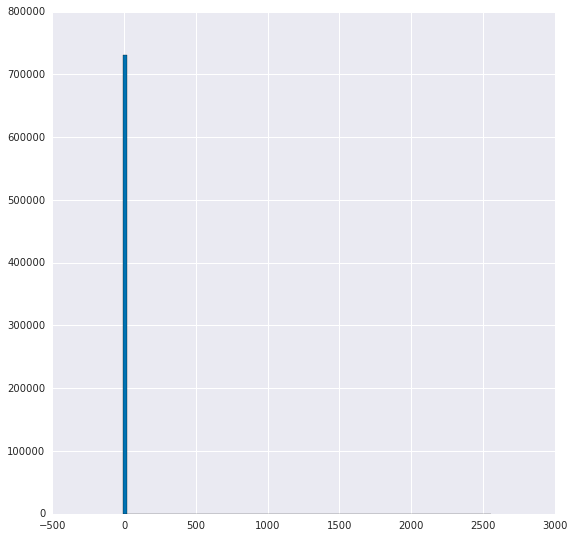

In [202]:
plt.hist( mkt_portion.flatten() , bins=80);

In [203]:
(mkt_portion>1).nonzero()

(array([  15,   46,   47,   58,   69,   72,   86,   94,  111,  131,  138,
         186,  195,  228,  259,  266,  285,  300,  308,  324,  337,  338,
         380,  387,  422,  427,  446,  451,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  480,  480,  480,  480,  480,  480,  480,  480,  480,
         480,  480,  482,  483,  485,  508,  518,  562,  563,  565,  577,
         587,  606,  613,  620,  622,  627,  634,  639,  679,  703,  714,
         761,  772,  774,  778,  790,  799,  809,  816,  818,  824,  832,
         876,  882,  895,  896,  904,  910,  930,  940,  959,  964,  986,
         988, 1012, 1024, 1029, 1038, 

In [214]:
f.components_[0, 187]

0.99965895190393317

In [205]:
residual.iloc[:,187]

groupbyTime
2009-01-02 22:00:00+00:00    2.666796
2009-01-05 22:00:00+00:00    2.683948
2009-01-06 22:00:00+00:00    2.726037
2009-01-07 22:00:00+00:00    2.717924
2009-01-08 22:00:00+00:00    2.590186
2009-01-09 22:00:00+00:00    2.683295
2009-01-12 22:00:00+00:00    2.822440
2009-01-13 22:00:00+00:00    2.677635
2009-01-14 22:00:00+00:00    2.822642
2009-01-15 22:00:00+00:00    2.408974
2009-01-16 22:00:00+00:00    2.997341
2009-01-20 22:00:00+00:00    2.594979
2009-01-21 22:00:00+00:00    2.640183
2009-01-22 22:00:00+00:00    2.663916
2009-01-23 22:00:00+00:00    2.666953
2009-01-26 22:00:00+00:00    2.614923
2009-01-27 22:00:00+00:00    2.743190
2009-01-28 22:00:00+00:00    2.786772
2009-01-29 22:00:00+00:00    2.777259
2009-01-30 22:00:00+00:00    2.348598
2009-02-02 22:00:00+00:00    2.445574
2009-02-03 22:00:00+00:00    2.521683
2009-02-04 22:00:00+00:00    2.517948
2009-02-05 22:00:00+00:00    2.726596
2009-02-06 22:00:00+00:00    2.552867
2009-02-09 22:00:00+00:00    2.600703


In [208]:
theNW.iloc[:,187]

groupbyTime
2009-01-02 22:00:00+00:00     0.000000
2009-01-05 22:00:00+00:00     0.000000
2009-01-06 22:00:00+00:00     0.474962
2009-01-07 22:00:00+00:00     0.055556
2009-01-08 22:00:00+00:00     0.000000
2009-01-09 22:00:00+00:00     0.000000
2009-01-12 22:00:00+00:00     0.353554
2009-01-13 22:00:00+00:00     0.000000
2009-01-14 22:00:00+00:00     3.218779
2009-01-15 22:00:00+00:00     1.128560
2009-01-16 22:00:00+00:00     0.000000
2009-01-20 22:00:00+00:00     2.076982
2009-01-21 22:00:00+00:00     1.316230
2009-01-22 22:00:00+00:00     2.474346
2009-01-23 22:00:00+00:00     0.423199
2009-01-26 22:00:00+00:00    21.966311
2009-01-27 22:00:00+00:00     1.004499
2009-01-28 22:00:00+00:00     0.682255
2009-01-29 22:00:00+00:00     0.000000
2009-01-30 22:00:00+00:00     0.095347
2009-02-02 22:00:00+00:00     0.000000
2009-02-03 22:00:00+00:00     0.170561
2009-02-04 22:00:00+00:00     2.000002
2009-02-05 22:00:00+00:00     1.000001
2009-02-06 22:00:00+00:00     0.000000
2009-02-09 22

In [207]:
assetNameIdAssign.series[191]

'Biomet Inc'

In [ ]:
'''conclusion: PCA on news doesn't work ''';

In [218]:
data = NWpost2009.countRelevance.fillna(0)
# How to do ZCA using sklearn's PCA
# c.f. Michael Eickenberg on Google https://groups.google.com/forum/#!topic/theano-users/_63ggUdWeEI
pca = PCA(whiten=True)
transformed = pca.fit_transform(data)
pca.whiten = False
zca = pca.inverse_transform(transformed)

In [221]:
zca.shape

((2014, 3438), (2014, 3438))

### Nonnegative matrix factorization

In [257]:
f = NMF(n_components=1)
f = f.fit(data)

In [258]:
f.reconstruction_err_

6265.73036493163

In [256]:
np.sqrt((data.values.flatten()**2).sum())

6855.2136519453361

In [254]:
data*0 + f.inverse_transform(f.transform(data))

assetNameId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,...,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509
groupbyTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02 22:00:00+00:00,0.295290,0.250389,0.037030,0.475051,0.294332,0.184532,0.095174,0.083864,0.915139,0.038964,0.018773,0.450616,0.166269,0.112869,0.007983,0.061189,0.182911,0.104691,0.094551,0.195815,0.174864,...,0.033966,0.000082,0.014366,0.000811,0.000004,0.000382,0.011539,0.008976,0.001275,0.000684,0.000232,0.000370,0.079504,0.000256,0.028513,0.000677,0.008567,0.000670,0.000406,0.002219,0.013013
2009-01-05 22:00:00+00:00,0.643687,0.264258,0.196134,19.326820,0.501875,0.377970,0.141375,0.155983,0.890320,0.059233,0.035221,0.640167,0.156366,0.089798,0.098881,0.164831,0.310099,0.128132,0.370331,0.852754,0.478800,...,0.319312,0.000361,0.160028,0.001037,0.000008,0.003491,0.327812,0.061594,0.036381,0.000004,0.001522,0.001268,0.098778,0.001438,0.045962,0.000826,0.045404,0.003027,0.001201,0.004191,0.208966
2009-01-06 22:00:00+00:00,0.836984,0.284042,0.183345,36.539200,0.840308,0.510106,0.254475,0.178793,1.334383,0.059492,0.032821,0.742441,0.159664,0.101495,0.111058,0.243093,0.451747,0.126386,0.517275,0.819906,0.650995,...,0.313413,0.000643,0.284639,0.001787,0.000026,0.004453,0.296662,0.061494,0.035976,0.003155,0.001816,0.001980,0.171196,0.003058,0.070631,0.000918,0.065528,0.003881,0.001785,0.018241,0.368475
2009-01-07 22:00:00+00:00,0.800876,0.513013,0.160476,3.935068,0.597364,0.290438,0.179422,0.209545,1.942929,0.080715,0.094205,1.104533,0.339561,0.195621,0.081433,0.194195,0.536192,0.209198,0.324328,0.669157,0.327201,...,0.164416,0.000728,0.061087,0.000961,0.000025,0.001960,0.177993,0.094926,0.019134,0.000620,0.002392,0.002993,0.106135,0.003303,0.074173,0.002667,0.031678,0.005569,0.031038,0.011321,0.061819
2009-01-08 22:00:00+00:00,0.943606,0.464887,0.310465,2.084187,0.714942,0.401855,0.331055,0.265049,2.297581,0.094430,0.093152,1.125574,0.291207,0.178614,0.184669,0.425177,0.760266,0.172169,0.299058,0.998959,0.642767,...,0.417908,0.001867,0.055115,0.001110,0.000061,0.004827,0.490891,0.228514,0.055393,0.000013,0.005806,0.006597,0.116888,0.009206,0.098250,0.003149,0.088983,0.012937,0.045217,0.030754,0.052779
2009-01-09 22:00:00+00:00,0.783561,0.603544,0.121494,1.506449,0.683864,0.191096,0.343133,0.250380,2.887685,0.091087,0.018637,1.225296,0.378069,0.263667,0.036732,0.195269,0.691794,0.218980,0.203861,0.396825,0.422972,...,0.095737,0.002186,0.056013,0.001678,0.000090,0.017473,0.087374,0.049628,0.025559,0.040488,0.002505,0.004651,0.090274,0.006942,0.071735,0.001720,0.084684,0.013380,0.021810,0.115257,0.040167
2009-01-12 22:00:00+00:00,0.997673,0.694011,0.240598,1.505645,0.958022,0.622109,0.398760,0.291327,3.107647,0.133219,0.032132,1.283550,0.454053,0.340527,0.096925,0.328871,0.700031,0.275097,0.265242,0.749610,0.761511,...,0.329944,0.000802,0.033904,0.002378,0.000032,0.003147,0.305811,0.096943,0.035484,0.000017,0.002609,0.002935,0.233002,0.004085,0.084952,0.002254,0.070120,0.005194,0.006792,0.014424,0.045569
2009-01-13 22:00:00+00:00,1.045449,0.784312,0.135862,1.588494,0.906582,0.361401,0.368942,0.291790,3.281432,0.114574,0.046858,1.619675,0.501406,0.333556,0.024357,0.209160,0.815887,0.305125,0.388519,0.571986,0.521060,...,0.091044,0.001794,0.063710,0.002390,0.000081,0.015706,0.049075,0.025160,0.019482,0.037074,0.001858,0.004042,0.165699,0.005237,0.093896,0.003306,0.075754,0.011034,0.020003,0.101325,0.044988
2009-01-14 22:00:00+00:00,0.960046,0.585991,0.174617,6.567151,0.970870,0.287616,0.304647,0.367856,3.040408,0.102374,0.000000,2.126488,0.411433,0.324813,0.081437,0.191714,0.872968,0.224586,0.355858,0.484833,0.659849,...,0.117893,0.006278,0.183062,0.004705,0.000204,0.060174,0.103072,0.141722,0.049044,0.144350,0.005782,0.011140,0.205514,0.012492,0.126301,0.003701,0.150039,0.046051,0.077711,0.356426,0.101704


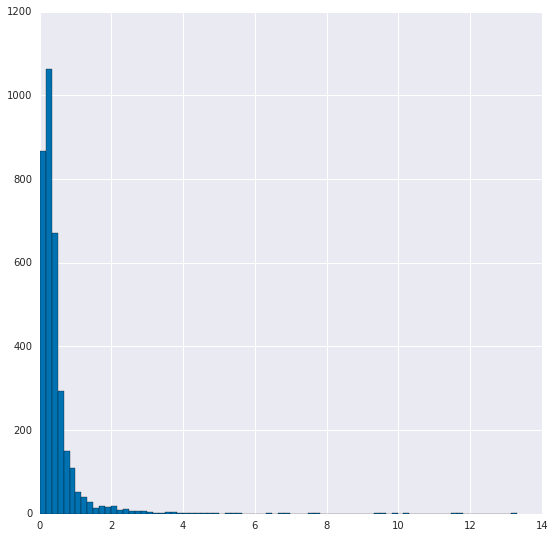

In [249]:
plt.hist( f.components_[0], bins=80);

### Correlations, plotting

In [268]:
MNspecial = MN[M.time>=train_start_time].groupby(['time','assetNameId'])[['oo','oo_10']].mean()

In [270]:
MNspec = MNspecial.reset_index()
MNspec2009 = MNspec[MNspec.time>=train_start_time]

In [274]:
W1 = MNspec2009[['time','assetNameId','oo']].pivot('time','assetNameId').oo
W10 = MNspec2009[['time','assetNameId','oo_10']].pivot('time','assetNameId').oo_10

In [276]:
lens(W1.columns,W10.columns,NWpost2009.countRelevance.columns)

(3780, 3780, 3438)

In [283]:
from sklearn.covariance import LedoitWolf

def get_corr_from_cov(covmat):
    d = np.diag(np.sqrt(np.diag(lw.covariance_)))
    return np.linalg.inv(d).dot(lw.covariance_).dot(np.linalg.inv(d))

lw = LedoitWolf()

lw.fit(W1[NWpost2009.countRelevance.columns].fillna(0))
corr = get_corr_from_cov(lw.covariance_)

lw.fit(NWpost2009.countRelevance.fillna(0))
corr2 = get_corr_from_cov(lw.covariance_)

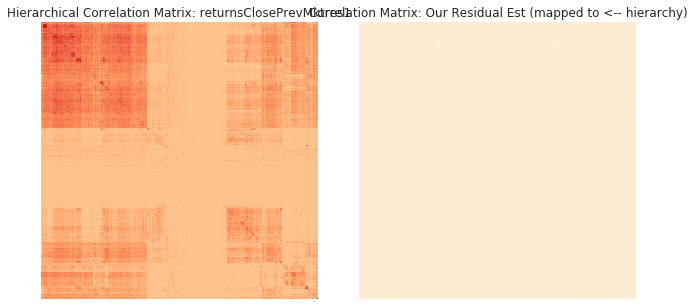

In [284]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

def plot_side_by_side_hm(corr, corr2, title1, title2):
    row_linkage = hierarchy.linkage(
        distance.pdist(corr), method='average')
    row_order = list(map(int, hierarchy.dendrogram(row_linkage, no_plot=True)['ivl']))
    
    col_linkage = hierarchy.linkage(
        distance.pdist(corr.T), method='average')
    col_order = list(map(int, hierarchy.dendrogram(col_linkage, no_plot=True)['ivl']))
    
    corr_swapped = np.copy(corr)
    corr_swapped[:, :] = corr_swapped[row_order, :]
    corr_swapped[:, :] = corr_swapped[:, col_order]

    corr_swapped2 = np.copy(corr2)
    corr_swapped2[:, :] = corr_swapped2[row_order, :]
    corr_swapped2[:, :] = corr_swapped2[:, col_order]

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.tight_layout()
    cs1 = sns.heatmap(corr_swapped, square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax1, cmap='OrRd')
    cs1.set_title(title1)
    cs2 = sns.heatmap(corr_swapped2, square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax2, cmap='OrRd')
    cs2.set_title(title2);

plot_side_by_side_hm(
    corr,
    corr2,
    'Hierarchical Correlation Matrix: returnsClosePrevMktres1',
    'Correlation Matrix: Our Residual Est (mapped to <-- hierarchy)'
)

In [286]:
corr2

array([[  1.00000000e+00,   8.50632011e-04,   2.09151812e-03, ...,
         -9.48956782e-04,   3.57265127e-04,  -4.17929806e-04],
       [  8.50632011e-04,   1.00000000e+00,  -1.16824222e-03, ...,
         -6.43180961e-04,  -1.61264550e-03,   1.81565605e-04],
       [  2.09151812e-03,  -1.16824222e-03,   1.00000000e+00, ...,
         -2.42906118e-04,  -6.99427937e-04,  -8.11074442e-04],
       ..., 
       [ -9.48956782e-04,  -6.43180961e-04,  -2.42906118e-04, ...,
          1.00000000e+00,   2.58279352e-04,  -1.11373881e-04],
       [  3.57265127e-04,  -1.61264550e-03,  -6.99427937e-04, ...,
          2.58279352e-04,   1.00000000e+00,   5.91325698e-04],
       [ -4.17929806e-04,   1.81565605e-04,  -8.11074442e-04, ...,
         -1.11373881e-04,   5.91325698e-04,   1.00000000e+00]])

### sparse PCA, vis via t-SNE

In [82]:
W.xx = (W.x_/w.std).clip(-5,5)

In [58]:
cntlog = np.log(mn.cnt)
cntlog = cntlog.fillna(cntlog.mean())

In [67]:
fSPCA = MBSparsePCA(12, verbose=3, alpha=60, n_iter=1000, random_state=78)
spca = fSPCA.fit_transform(cntlog)#(W.xx)

Iteration   0 (elapsed time:   0s,  0.0mn)
Iteration  34 (elapsed time:   0s,  0.0mn)
Iteration  68 (elapsed time:   0s,  0.0mn)
Iteration  102 (elapsed time:   0s,  0.0mn)
Iteration  136 (elapsed time:   0s,  0.0mn)
Iteration  170 (elapsed time:   0s,  0.0mn)
Iteration  204 (elapsed time:   0s,  0.0mn)
Iteration  238 (elapsed time:   0s,  0.0mn)
Iteration  272 (elapsed time:   1s,  0.0mn)
Iteration  306 (elapsed time:   1s,  0.0mn)
Iteration  340 (elapsed time:   1s,  0.0mn)
Iteration  374 (elapsed time:   1s,  0.0mn)
Iteration  408 (elapsed time:   1s,  0.0mn)
Iteration  442 (elapsed time:   1s,  0.0mn)
Iteration  476 (elapsed time:   1s,  0.0mn)
Iteration  510 (elapsed time:   1s,  0.0mn)
Iteration  544 (elapsed time:   1s,  0.0mn)
Iteration  578 (elapsed time:   2s,  0.0mn)
Iteration  612 (elapsed time:   2s,  0.0mn)
Iteration  646 (elapsed time:   2s,  0.0mn)
Iteration  680 (elapsed time:   2s,  0.0mn)
Iteration  714 (elapsed time:   2s,  0.0mn)
Iteration  748 (elapsed time:   2s,

125

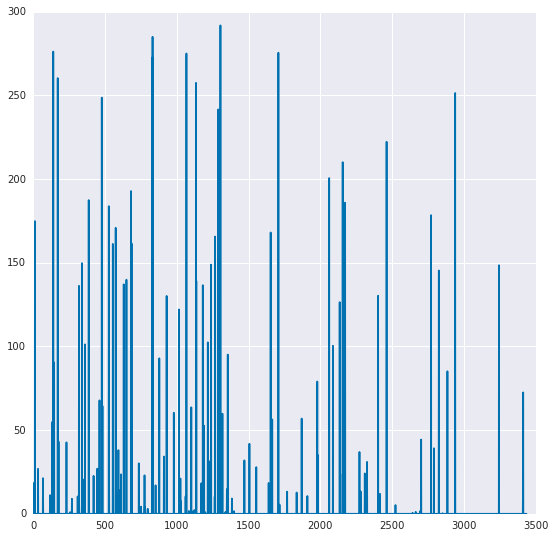

In [71]:
c = 0
plt.plot(fSPCA.components_[c]);
len(fSPCA.components_[c].nonzero()[0])

In [78]:
xGoodNames = set(mn.cnt.columns[(fSPCA.components_[0]>110).nonzero()[0]])

In [145]:
vis = TSNE(n_components=2, perplexity=10, n_iter=1000, metric='precomputed').fit_transform((1-Cqtl)**1)

#### HDBSCAN

In [61]:
hdb

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='precomputed', min_cluster_size=15, min_samples=3, p=None,
    prediction_data=False)

In [165]:
hdb = HDBSCAN(metric='precomputed', min_cluster_size=10, min_samples=1, alpha=.99, cluster_selection_method='eom')
hdb = hdb.fit(1-Cqtl)
hdb.N = pd.Series(hdb.labels_).nunique() - 1
assert -1 in hdb.labels_
pd.Series(hdb.labels_).value_counts()

-1    407
 2    112
 1     43
 0     29
 3     22
dtype: int64

In [169]:
%matplotlib notebook
canvas(9, 6)

<IPython.core.display.Javascript object>


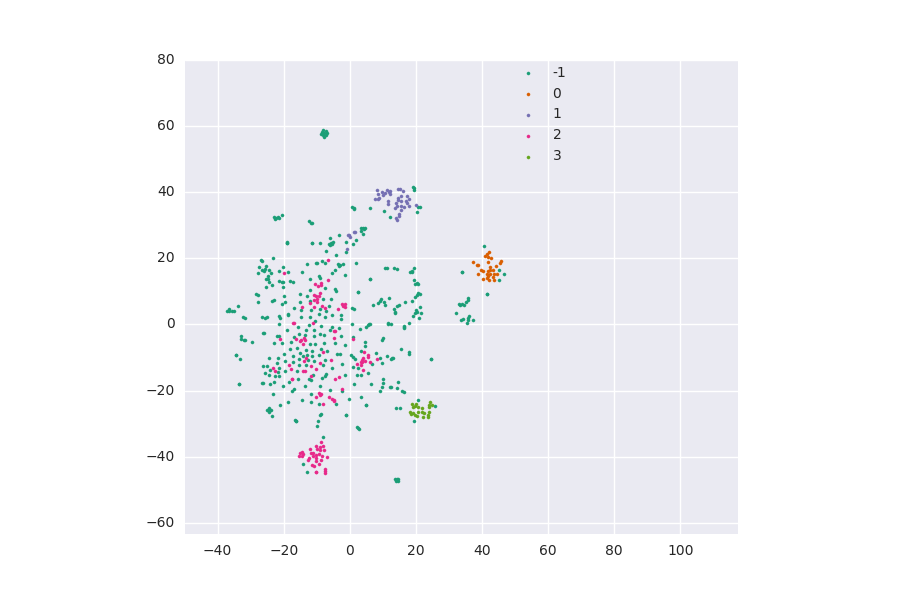

In [183]:
m_styles = markers.MarkerStyle.markers
N = hdb.N
colormap = plt.cm.Dark2.colors   # Qualitative colormap
fig, ax = plt.subplots(1, 1)
for i,(marker,color) in zip(range(-1,N),itertools.product(m_styles, colormap)):
    ax.scatter(*vis[hdb.labels_==i].T, color=color, marker=marker, label=i)
ax.legend(bbox_to_anchor=(.7, 1), loc=1, borderaxespad=0.,ncol=1);
ax.set_aspect('equal')

In [116]:
%matplotlib inline

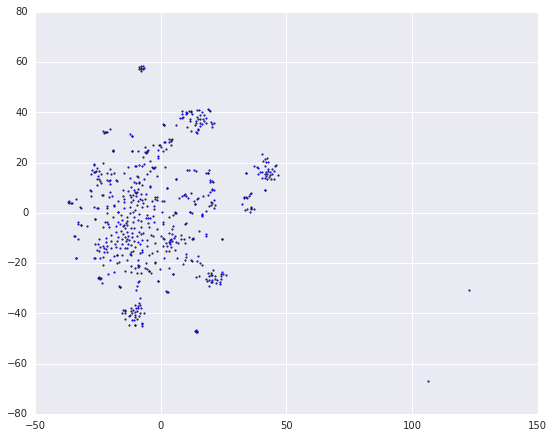

In [146]:
canvas(9,9)
fig, ax = plt.subplots(1, 1)
ax.scatter(vis[:, 0], vis[:, 1], s=3, alpha=.9);
#, c=hdb.labels_, cmap=plt.get_cmap('spectral', hdb.N+1));
#plt.colorbar(ticks=list(range(-1, hdb.N)));
ax.set_aspect('equal')

In [34]:
f = PCA(7)
f = f.fit(W.oo_10_.T)
W.oo_10.pca = f.transform(W.oo_10_.T)

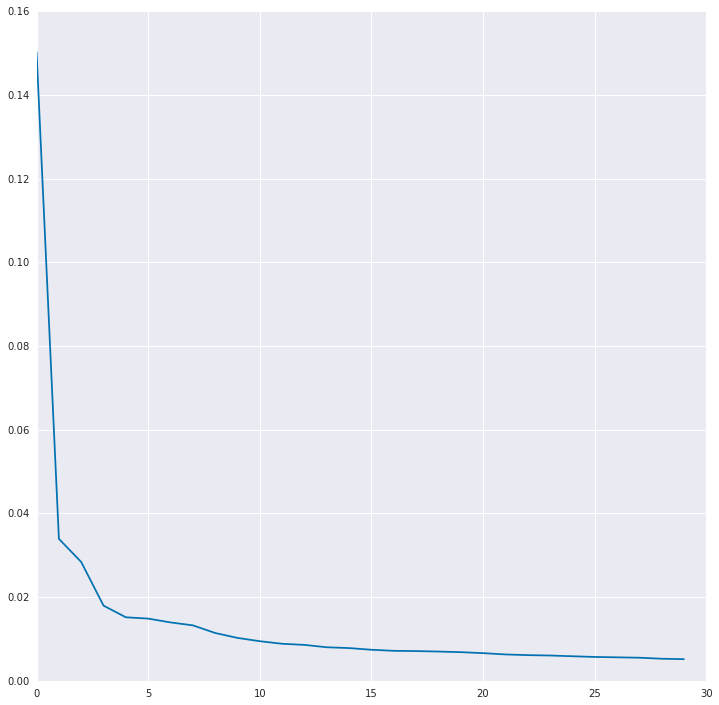

In [33]:
plt.plot(range(30), f.explained_variance_ratio_[:30]);

In [ ]:
vis = TSNE(n_components=2, perplexity=10, n_iter=1000, metric='precomputed').fit_transform((1-C.oo_10)**4)
plt.scatter(vis[:, 0], vis[:, 1], s=3, alpha=.9);

In [9]:
import pickle
with open('hi.txt', 'wb') as file:
    pickle.dump("hi", file)

In [23]:
lim = 80

In [24]:
from __future__ import print_function

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold

print(__doc__)



symbols = assetCodeSeries.iloc[:lim]

# The daily variations of the quotes are what carry most information
variation = None


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = W.oo_10.iloc[:,:lim].fillna(0).values
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
with open('labels.pkl', 'wb') as file:
    pickle.dump(labels, file)
    
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(symbols[labels == i])))



Automatically created module for IPython interactive environment
Cluster 1: ABD.N
Cluster 2: ABV.N
Cluster 3: ABY.N, AD.N, AEA.N, AFR.N, ALO.N
Cluster 4: ACTS.O
Cluster 5: ADI.N, AET.N
Cluster 6: AEOS.O
Cluster 7: ABT.N, AEE.N, AEP.N
Cluster 8: AES.N
Cluster 9: AAP.N, ABC.N, ABM.N, ADM.N, ADP.N, AF.N, AFFX.O, AFG.N, AFL.N, AHL.N, AINV.O, AJG.N, ALD.N, ALK.N, ALL.N, AMED.O, AMGN.O
Cluster 10: AGE.N, AH.N
Cluster 11: AHG.N
Cluster 12: AHS.N
Cluster 13: AAI.N, AAPL.O, ABB.N, ACF.N, ACH.N, ADBE.O, ADCT.O, ADTN.O, AHT.N, AIN.N, AIR.N, AKAM.O, AKS.N, ALB.N, ALTR.O, ALU.N, ALV.N, AMD.N, AME.N, AMKR.O
Cluster 14: A.N, ACL.N, ACS.N, ACXM.O, ADS.N, ADSK.O, AEG.N, AEIS.O, AEL.N, AER.N, AG.N, AGN.N, AGU.N, AIT.N, AIV.N, AIZ.N, AKR.N, ALGN.O, ALNY.O, ALXN.O, AMAT.O, AMG.N, AMLN.O, AMMD.O


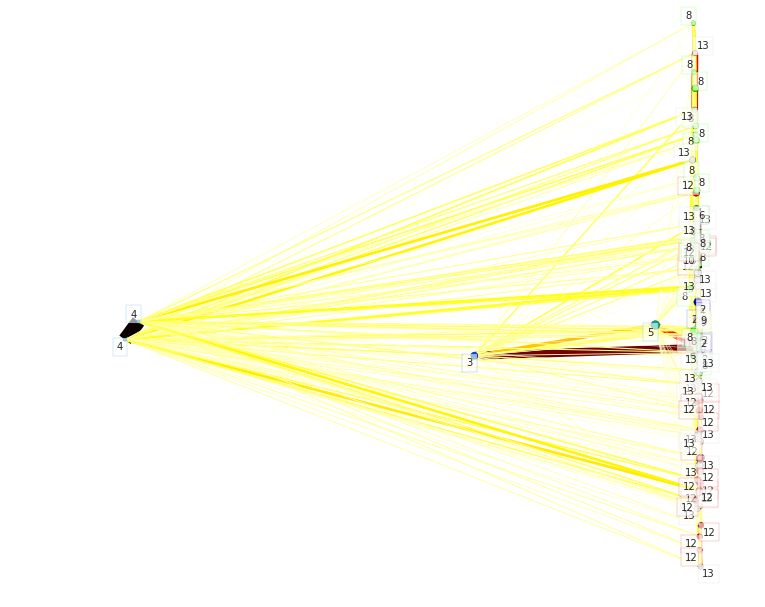

In [25]:
# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T
with open('embedding.pkl', 'wb') as file:
    pickle.dump(labels, file)

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (symbol, label, (x, y)) in enumerate(
        zip(symbols, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, label, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()